## 1. Univariate Analysis
    1.1 Customer Count Distribution

1.1.1 By Gender

In [3]:
import pandas as pd

In [4]:
tempdf = pd.read_parquet('data/Transactions_Cleaned.parquet')

print("DataFrame loaded successfully!")
print(f"Shape of loaded DataFrame: {tempdf.shape}")
print("\nData Types:")
print(tempdf.info())

DataFrame loaded successfully!
Shape of loaded DataFrame: (984247, 10)

Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984247 entries, 0 to 984246
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            984247 non-null  object        
 1   CustomerID               984247 non-null  object        
 2   CustomerDOB              984247 non-null  datetime64[ns]
 3   CustGender               984247 non-null  object        
 4   CustLocation             984247 non-null  object        
 5   CustAccountBalance       984247 non-null  float64       
 6   TransactionDate          984247 non-null  datetime64[ns]
 7   TransactionTime          984247 non-null  object        
 8   TransactionAmount (INR)  984247 non-null  float64       
 9   Age                      984247 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
me

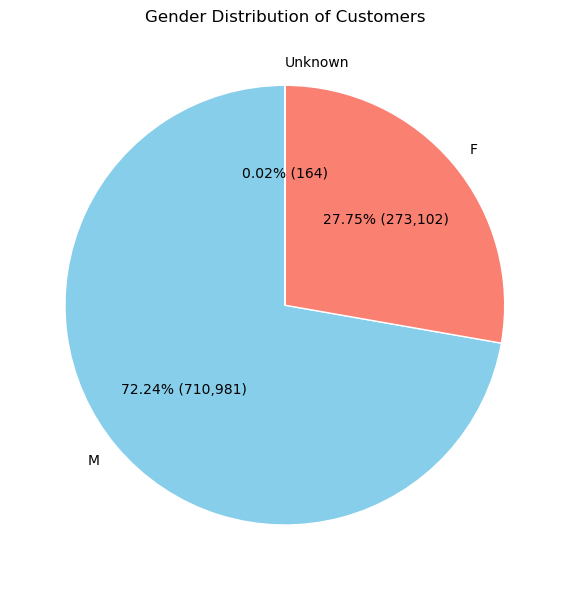

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

gender_counts = tempdf['CustGender'].value_counts()
labels = gender_counts.index
sizes = gender_counts.values
colors = ['skyblue', 'salmon']
total = sum(sizes)

def make_autopct(sizes):
    def autopct(pct):
        count = int(round(pct * total / 100.0))
        return f'{pct:.2f}% ({count:,})'
    return autopct

plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct=make_autopct(sizes),
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)

plt.title("Gender Distribution of Customers")
plt.tight_layout()
plt.show()

1.1.2 By Location

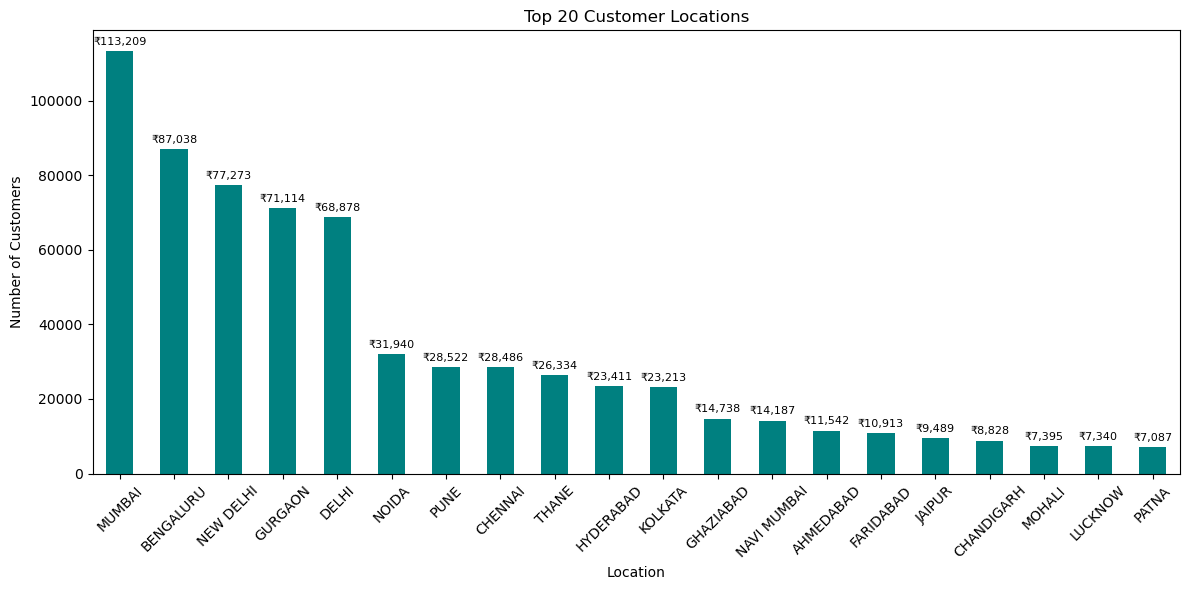

In [6]:
plt.figure(figsize=(12, 6))
top_locations = tempdf['CustLocation'].value_counts().head(20)

ax = top_locations.plot(kind='bar', color='teal')

for i, count in enumerate(top_locations):
    ax.annotate(f'₹{count:,}', 
                xy=(i, count), 
                xytext=(0, 3), 
                textcoords='offset points',
                ha='center', va='bottom', fontsize=8)

plt.title("Top 20 Customer Locations")
plt.ylabel("Number of Customers")
plt.xlabel("Location")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1.1.3 By Age

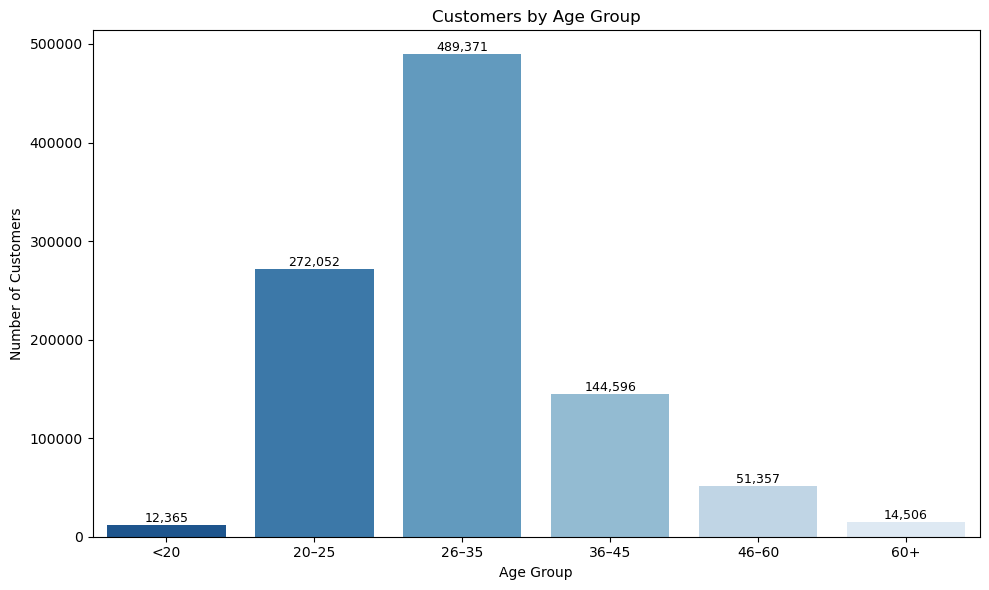

In [25]:
age_bins = [0, 19, 25, 35, 45, 60, tempdf['Age'].max()]
age_labels = ['<20', '20–25', '26–35', '36–45', '46–60', '60+']

tempdf['age_group'] = pd.cut(tempdf['Age'], bins=age_bins, labels=age_labels, include_lowest=True)

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='age_group', data=tempdf, hue = 'age_group', palette='Blues_r', order=age_labels, legend = False)

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count:,}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=9)

plt.title("Customers by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()

## Skew Analysis
There is a clear skew in number of customers based on the above variables.

    1. Males comprise almost 170.37% more than females in numbers
    2. Customers are much more concentrated in metro and/or industrialized cities
    3. There are significantly more customers in the 26-35 Age range than other age groups.

## 2. Bivariate Analysis
    2.1 How do customers differ in account balances and spending?

2.1.1 Which gender is spending more on average?

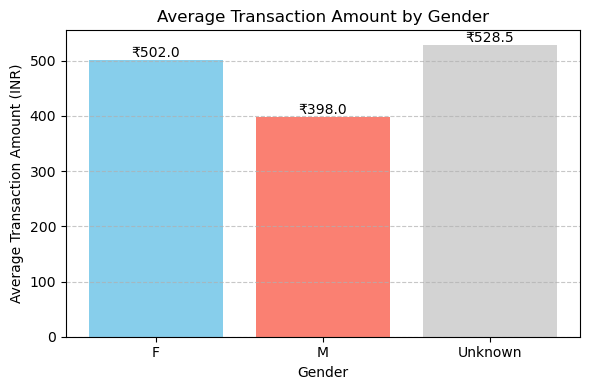

In [26]:
avg_spend_by_gender = tempdf.groupby('CustGender')['TransactionAmount (INR)'].median().reset_index()

plt.figure(figsize=(6, 4))
bars = plt.bar(avg_spend_by_gender['CustGender'], avg_spend_by_gender['TransactionAmount (INR)'], color=['skyblue', 'salmon', 'lightgrey'])
plt.title('Average Transaction Amount by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Transaction Amount (INR)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'₹{height:.1f}',
        ha='center',
        va='bottom'
    )
plt.tight_layout()
plt.show()

Which gender is spending more frequently?

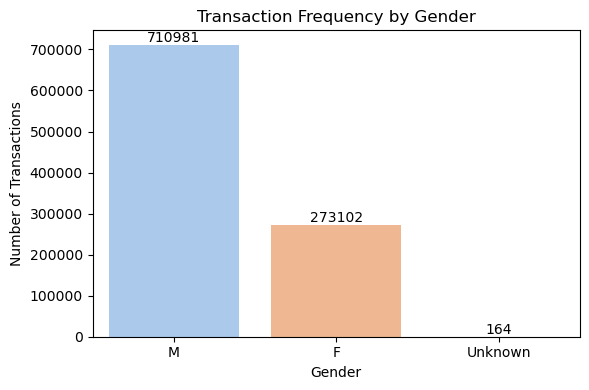

In [27]:
txn_counts_by_gender = tempdf['CustGender'].value_counts().reset_index()
txn_counts_by_gender.columns = ['CustGender', 'TransactionCount']

plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=txn_counts_by_gender,
    x='CustGender',
    hue='CustGender',
    y='TransactionCount',
    palette='pastel',
    legend=False
)

plt.title('Transaction Frequency by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Transactions')

for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

2.1.2 Which locations have higher account balances?
    
Focus will be on locations that fall within the top 20 customer count locations, since resources will be strategically allocated to areas with a signicantly large clientele.

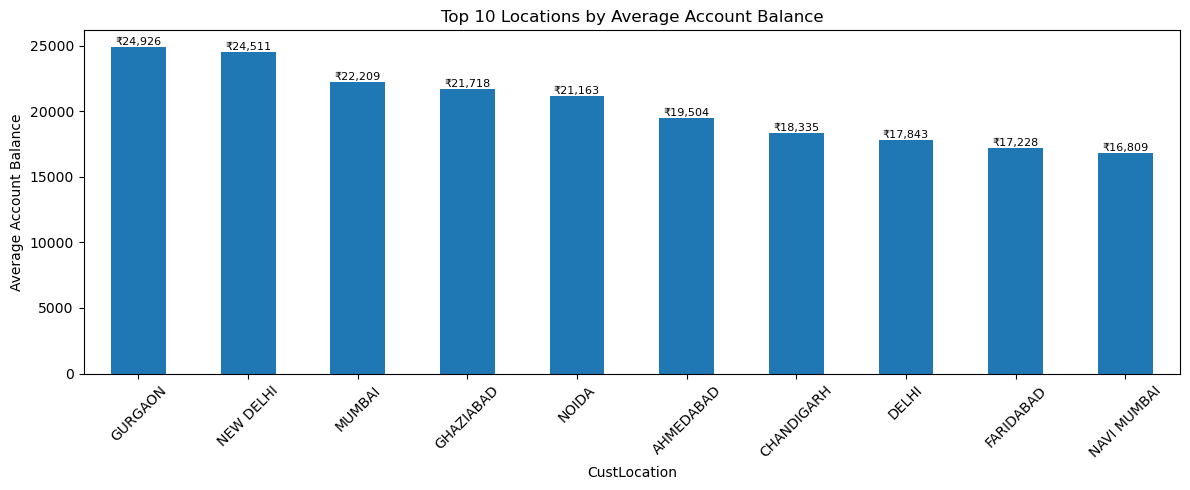

In [28]:
#top_locations points to top 20 locations, customer count- wise.
from matplotlib.ticker import ScalarFormatter

location_avg = (
    tempdf[tempdf['CustLocation'].isin(top_locations.index)]
    .groupby('CustLocation')['CustAccountBalance']
    .median()
    .sort_values(ascending=False)
    .head(10)
)

ax = location_avg.plot(kind='bar', figsize=(12,5))
plt.title("Top 10 Locations by Average Account Balance")
plt.ylabel("Average Account Balance")
plt.xticks(rotation=45)

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'₹{height:,.0f}',
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.tight_layout()
plt.show()

2.1.3 Which areas see higher transaction amounts on average?

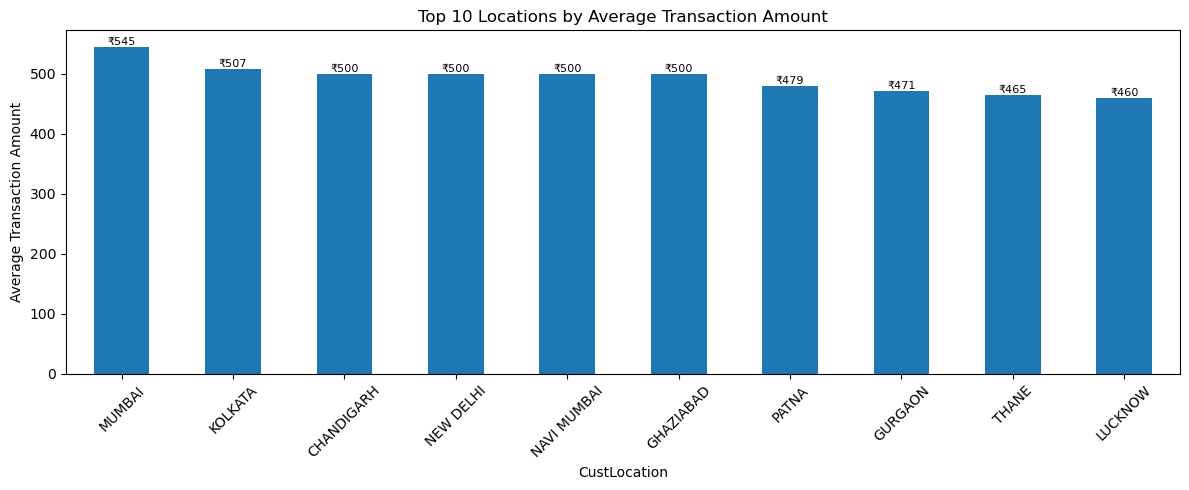

In [29]:
location_avg = (
    tempdf[tempdf['CustLocation'].isin(top_locations.index)]
    .groupby('CustLocation')['TransactionAmount (INR)']
    .median()
    .sort_values(ascending=False)
    .head(10)
)

ax = location_avg.plot(kind='bar', figsize=(12,5))
plt.title("Top 10 Locations by Average Transaction Amount")
plt.ylabel("Average Transaction Amount")
plt.xticks(rotation=45)

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'₹{height:,.0f}',
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.tight_layout()
plt.show()

2.1.4 Influence of Age on Spending Patterns

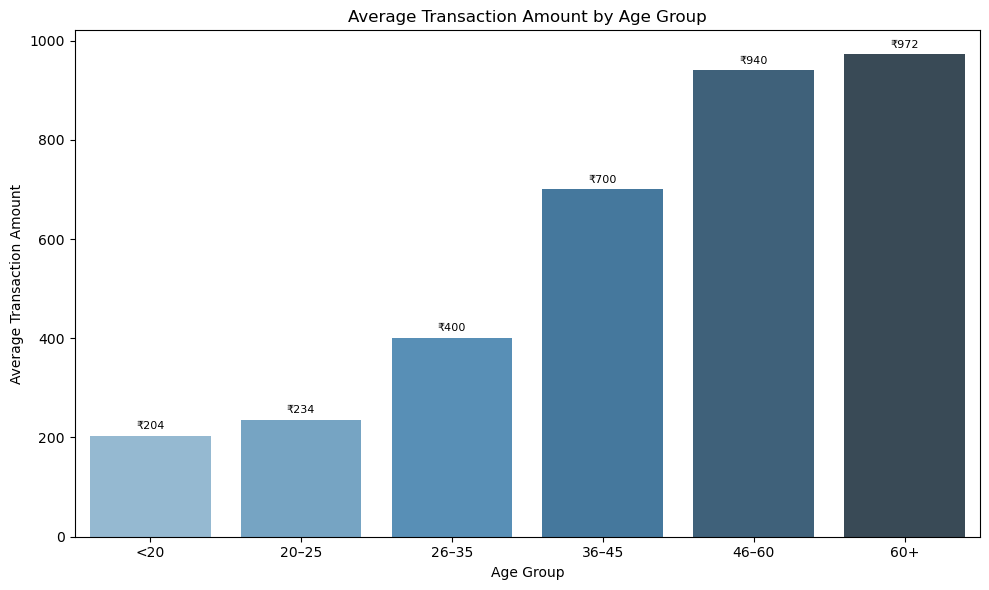

In [30]:
age_bins = [0, 20, 25, 35, 45, 60, float('inf')]
age_labels = ['<20', '20–25', '26–35', '36–45', '46–60', '60+']

tempdf['AgeGroup'] = pd.cut(tempdf['Age'], bins=age_bins, labels=age_labels, right=False)

txn_avg_age = tempdf.groupby('AgeGroup', observed=True)['TransactionAmount (INR)'].median().reindex(age_labels)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=txn_avg_age.index, y=txn_avg_age.values, hue=txn_avg_age.index, palette='Blues_d', legend=False)

for i, v in enumerate(txn_avg_age.values):
    ax.text(i, v + 0.01 * max(txn_avg_age.values), f'₹{int(v):,}', 
            ha='center', va='bottom', fontsize=8)

plt.title("Average Transaction Amount by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Transaction Amount")
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

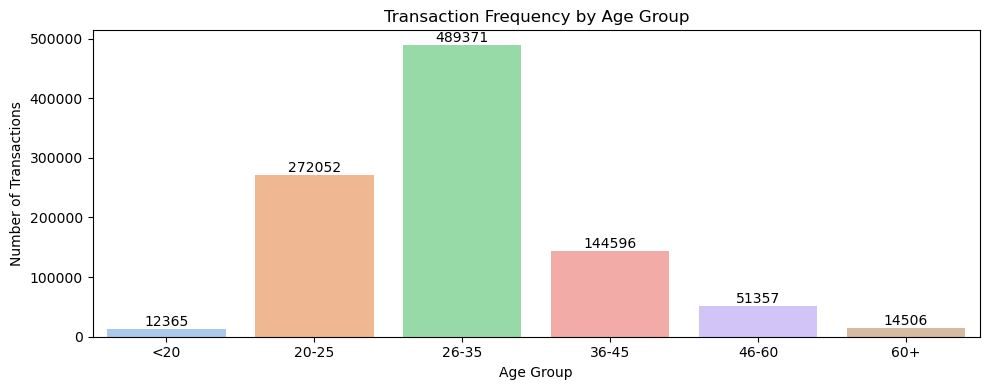

In [31]:
bins = [0, 19, 25, 35, 45, 60, float('inf')]
labels = ['<20', '20-25', '26-35', '36-45', '46-60', '60+']

tempdf['AgeGroup'] = pd.cut(tempdf['Age'], bins=bins, labels=labels, right=True)

txn_counts_by_age = tempdf['AgeGroup'].value_counts(sort=False).reset_index()
txn_counts_by_age.columns = ['AgeGroup', 'TransactionCount']

plt.figure(figsize=(10, 4))
ax = sns.barplot(data=txn_counts_by_age, x='AgeGroup', hue='AgeGroup', y='TransactionCount', palette='pastel', legend=False)

plt.title('Transaction Frequency by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Transactions')

for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

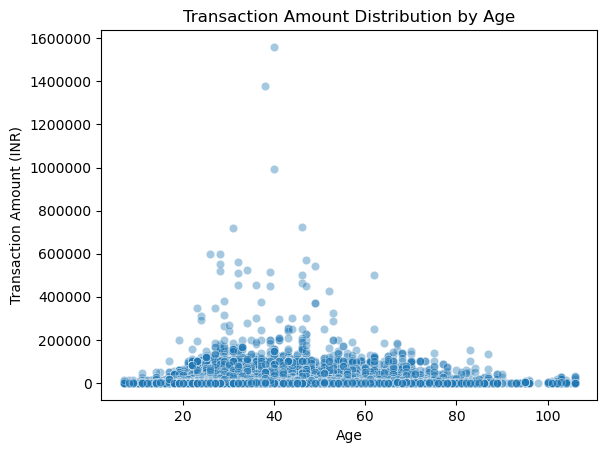

In [32]:
sns.scatterplot(data=tempdf, x='Age', y='TransactionAmount (INR)', alpha=0.4)
plt.title("Transaction Amount Distribution by Age")
plt.xlabel("Age")
plt.ylabel("Transaction Amount (INR)")
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.ticklabel_format(style='plain', axis='y')
plt.show()

## 3. Upsell/Cross-sell Strategies
    3.1 Relationship between Account Balance and Transaction Behaviour

3.1.1 Frequency of Transactions by Account Balance

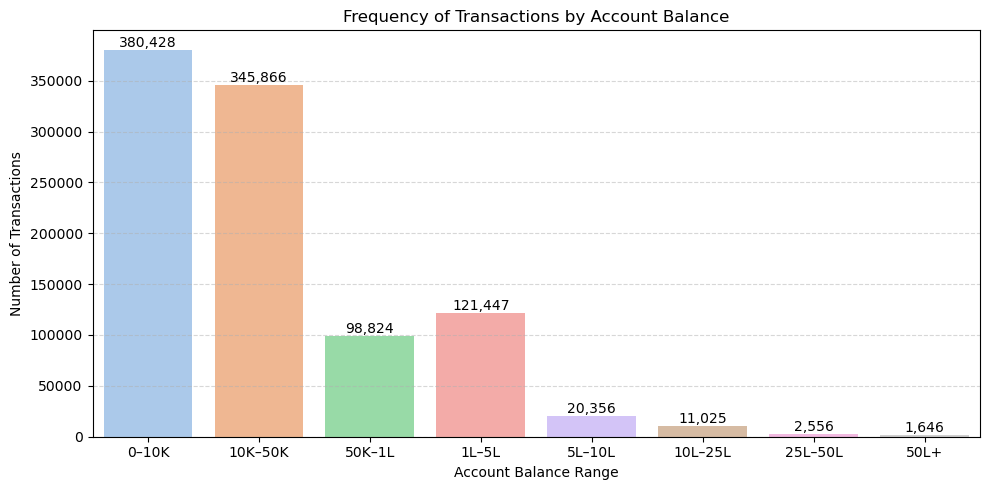

In [33]:
balance_bins = [0, 10_000, 50_000, 100_000, 500_000, 1_000_000, 2_500_000, 5_000_000, float('inf')]
balance_labels = ['0–10K', '10K–50K', '50K–1L', '1L–5L', '5L–10L', '10L–25L', '25L–50L', '50L+']

tempdf['AccountBalanceRange'] = pd.cut(tempdf['CustAccountBalance'], bins=balance_bins, labels=balance_labels)

balance_freq = tempdf['AccountBalanceRange'].value_counts(sort=False).reset_index()
balance_freq.columns = ['AccountBalanceRange', 'TransactionCount']

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=balance_freq, x='AccountBalanceRange', hue='AccountBalanceRange', y='TransactionCount', palette='pastel', legend=False)

for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height):,}',
        ha='center',
        va='bottom'
    )

plt.title("Frequency of Transactions by Account Balance")
plt.xlabel("Account Balance Range")
plt.ylabel("Number of Transactions")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

3.1.2 Correlation between Balance and Spending

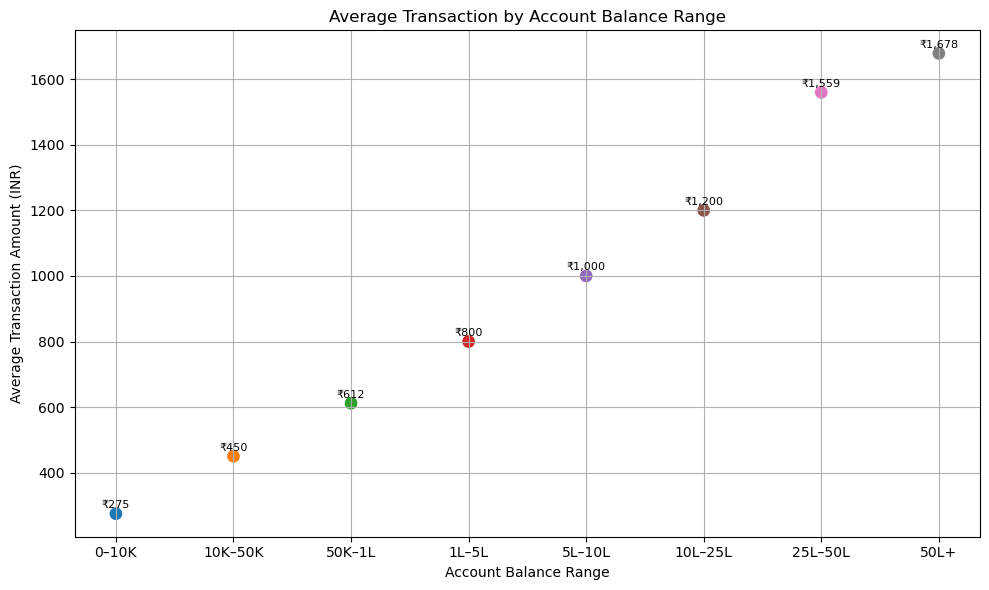

In [34]:
balance_bins = [0, 10_000, 50_000, 100_000, 500_000, 1_000_000, 2_500_000, 5_000_000, float('inf')]
balance_labels = ['0–10K', '10K–50K', '50K–1L', '1L–5L', '5L–10L', '10L–25L', '25L–50L', '50L+']

tempdf['BalanceBin'] = pd.cut(tempdf['CustAccountBalance'], bins=balance_bins, labels=balance_labels, include_lowest=True)

grouped = tempdf.groupby('BalanceBin', observed=True)['TransactionAmount (INR)'].median().reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped, x='BalanceBin', y='TransactionAmount (INR)', hue='BalanceBin', s=100, color='darkblue', legend=False)

for i, row in grouped.iterrows():
    plt.text(i, row['TransactionAmount (INR)'] + 0.01 * max(grouped['TransactionAmount (INR)']), 
             f"₹{int(row['TransactionAmount (INR)']):,}", 
             ha='center', fontsize=8)

plt.title("Average Transaction by Account Balance Range")
plt.xlabel("Account Balance Range")
plt.ylabel("Average Transaction Amount (INR)")
plt.grid(True)
plt.tight_layout()
plt.show()